# Make images for the paper

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.signal import medfilt2d

from funcs import *

%matplotlib notebook

In [2]:
# load the spectra we want to work with
line = 'k'
date = np.load('dates.npy')
rv = np.load('rv-'+line+'.npy')
spec = np.load('allspec-'+line+'.npy')
std = np.load('std.npy')
mean_spec = np.load('meanspec-'+line+'.npy')
mean_spec_nocs = np.load('meanspec-nocs-'+line+'.npy')

# throw out anything worse than this
std_thresh = 0.03

In [3]:
# get the best fit parameters
fits = np.load('parabolic.npy')
fit_dates = np.load('dates_fit.npy')

In [4]:
# grab a set of date ranges to work with
date_ranges = ()
for i,d in enumerate(date):
    prev = (date < d) & (date > d-0.5)
    post = (date > d) & (date < d+0.5)
    if np.sum(prev) == 0 and np.sum(post) > 30:
        date_ranges += ([np.min(date[post]),np.max(date[post])],)

In [5]:
def rebin(a, f):
    return a.reshape((len(a)//f, f)).mean(1)

83 spectra in 19 bins


<IPython.core.display.Javascript object>


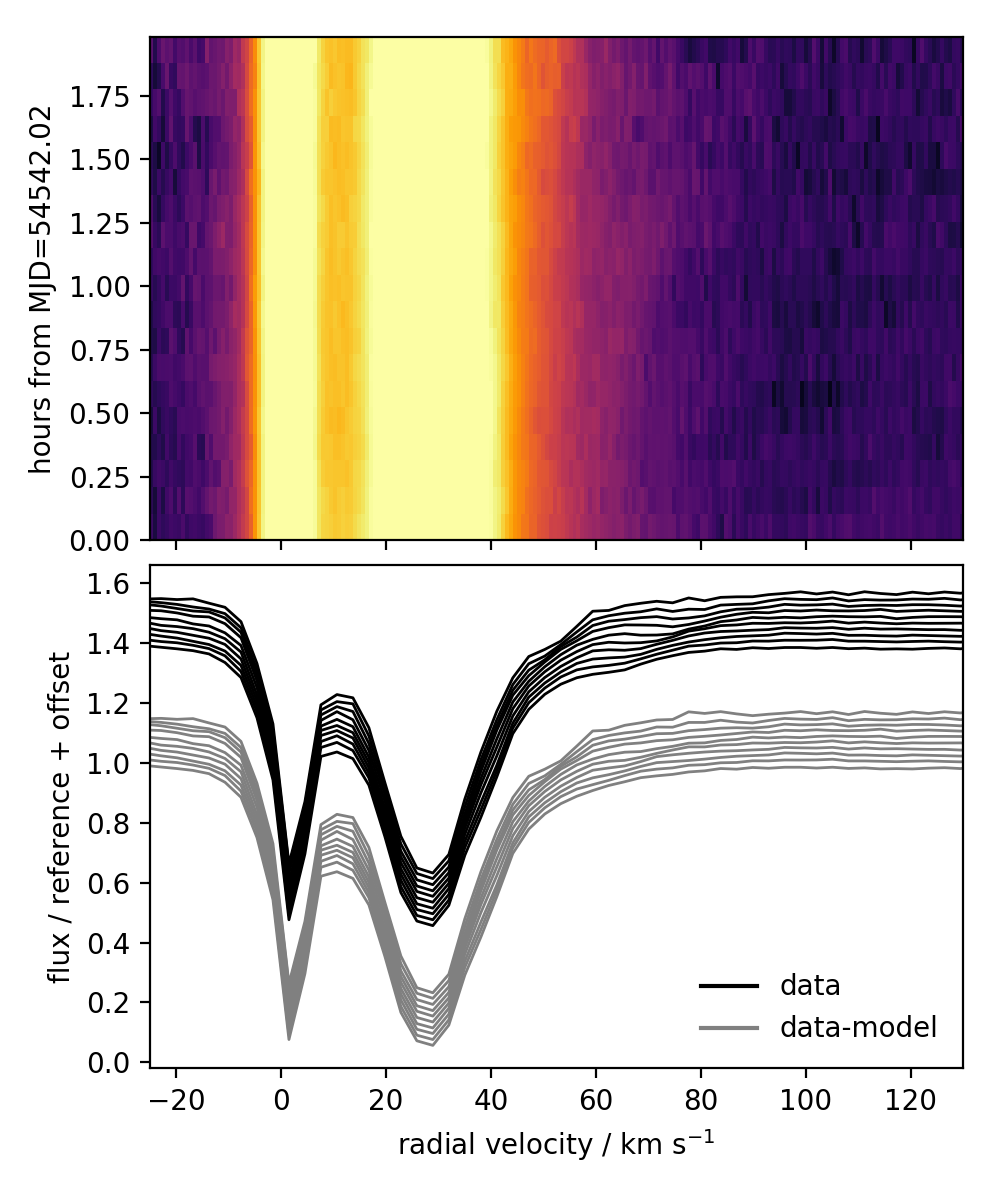

In [16]:
# make plots for these ranges
for d1, d2 in date_ranges[:1]:
    ds = np.linspace(d1, d2, int((d2 - d1)*250))
    img = np.zeros((len(ds)-1,len(spec[0])))
    nspec = 0
    for i in range(len(ds)-1):
        ok = (date > ds[i]) & (date <= ds[i+1]) & (std < std_thresh)
        nspec += np.sum(ok)
        if np.any(ok):
            img[i,:] = np.mean(spec[ok,:],axis=0)

    print('{} spectra in {} bins'.format(nspec, img.shape[0]))
    
    hs = (ds - ds[0]) * 24
    hs_cen = (hs[1:]+hs[:-1])/2.
    ok = np.sum(img,axis=1) != 0
    med = np.median(img[ok], axis=0)
    sub = np.zeros((img.shape))
    for i,im in enumerate(img):
        if np.sum(im) > 0:
            sub[i] = im - med

    filt = medfilt2d(sub, kernel_size=(3,131))
    sub -= filt
    img -= filt

    # get the model
    f = glob.glob('/Users/grant/a-extra/archive/fits_calx/{}*/para_best_par.npy'.format(int(round(d1))))
    best = np.load(f[0])
    mod, vel = model(best, [rv, img, med, 1, hs_cen])
    img -= mod
    
    fig,ax = plt.subplots(2, figsize=(5,6), sharex=True)
#                          gridspec_kw={'height_ratios': [3, 3, 3, 1]})
    
#     img_show = -img/mean_spec_nocs
#     img_show = -np.arcsin(img/mean_spec_nocs)
#     img_show = np.arcsinh(100*(1-img/mean_spec_nocs))
    img_show = np.log(1.1 - img/mean_spec_nocs)
    ax[0].imshow(img_show, origin='bottom', aspect='auto', 
                 vmin=-2.5, vmax=-0.5,
#                  vmin=-1, vmax=-0.6,
                 cmap='inferno',
                 extent=(rv[0],rv[-1],hs[0],hs[-1]))
    ax[0].set_ylabel('hours from MJD={:8.2f}'.format(ds[0]))
    ax[0].text(170, 1.7, 'ln(1-flux/reference)', color='white')
#     ax[0].text(170, 1.7, 'ln(1-[flux-model]/reference)', color='white')
    
#     in_tr, rv_mod = orbit_rv(nu, q, t0, hs, e=1)
#     if (np.max(rv_mod)-np.min(rv_mod)) > 1.3e3:
#         ax[0].plot(rv_mod[in_tr]/1e3, hs[in_tr], ':w', linewidth=2, alpha=0.3)

#     ax[1].imshow(sub, origin='bottom', aspect='auto', 
#                  vmin=-2e-2, vmax=2e-2, cmap='viridis',
#                  extent=(rv[0],rv[-1],hs[0],hs[-1]))
#     ax[1].text(190, 1.7, 'median subtracted', color='white',
#                bbox=dict(facecolor='black', alpha=1))
    
    # data (model added back in)
    for i in np.arange(0, img.shape[0], 2):
        ax[1].plot(rebin(rv,4), 0.4 + i/100. + rebin(np.mean((img+mod)[i:i+4],axis=0),4)/rebin(mean_spec,4),
                   color='black', linewidth=1, alpha=1)
        
    # model subtracted
    for i in np.arange(0, img.shape[0], 2):
        ax[1].plot(rebin(rv,4), i/100. + rebin(np.mean(img[i:i+4],axis=0),4)/rebin(mean_spec,4),
                   color='grey', linewidth=1, alpha=1)
    
#     ax[3].plot(rv, np.ones(rv.shape), '--', color='grey', label='reference')
#     for s in img:
#         ax[3].plot(rv, s/mean_spec_nocs, alpha=0.2, color='grey')
# #     ax[3].plot(rv, med/mean_spec_nocs, label='median/reference')
#     ax[3].set_xlabel('rv, km s$^{-1}$')
#     ax[3].set_ylabel('rel. flux')
#     ax[3].set_ylim(0,1.1)
#     ax[3].legend(frameon=False, loc=4)

    ax[0].set_xlim(np.min(rv), np.max(rv))
    ax[1].set_xlabel('radial velocity / km s$^{-1}$')
    ax[1].set_ylabel('flux / reference + offset')
    gr = mlines.Line2D([], [], color='black', label='data')
    bl = mlines.Line2D([], [], color='grey', label='data-model')
    ax[1].legend(handles=[gr,bl], frameon=False)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)
    fig.savefig('figs/nightly/{:5.0f}_'.format(ds[0])+line+'.eps')
    
    ax[0].set_xlim(-25,130)
#     ax[0].set_xlim(-100,250)
    fig.savefig('figs/nightly/{:5.0f}_'.format(ds[0])+line+'_z.eps')

<IPython.core.display.Javascript object>


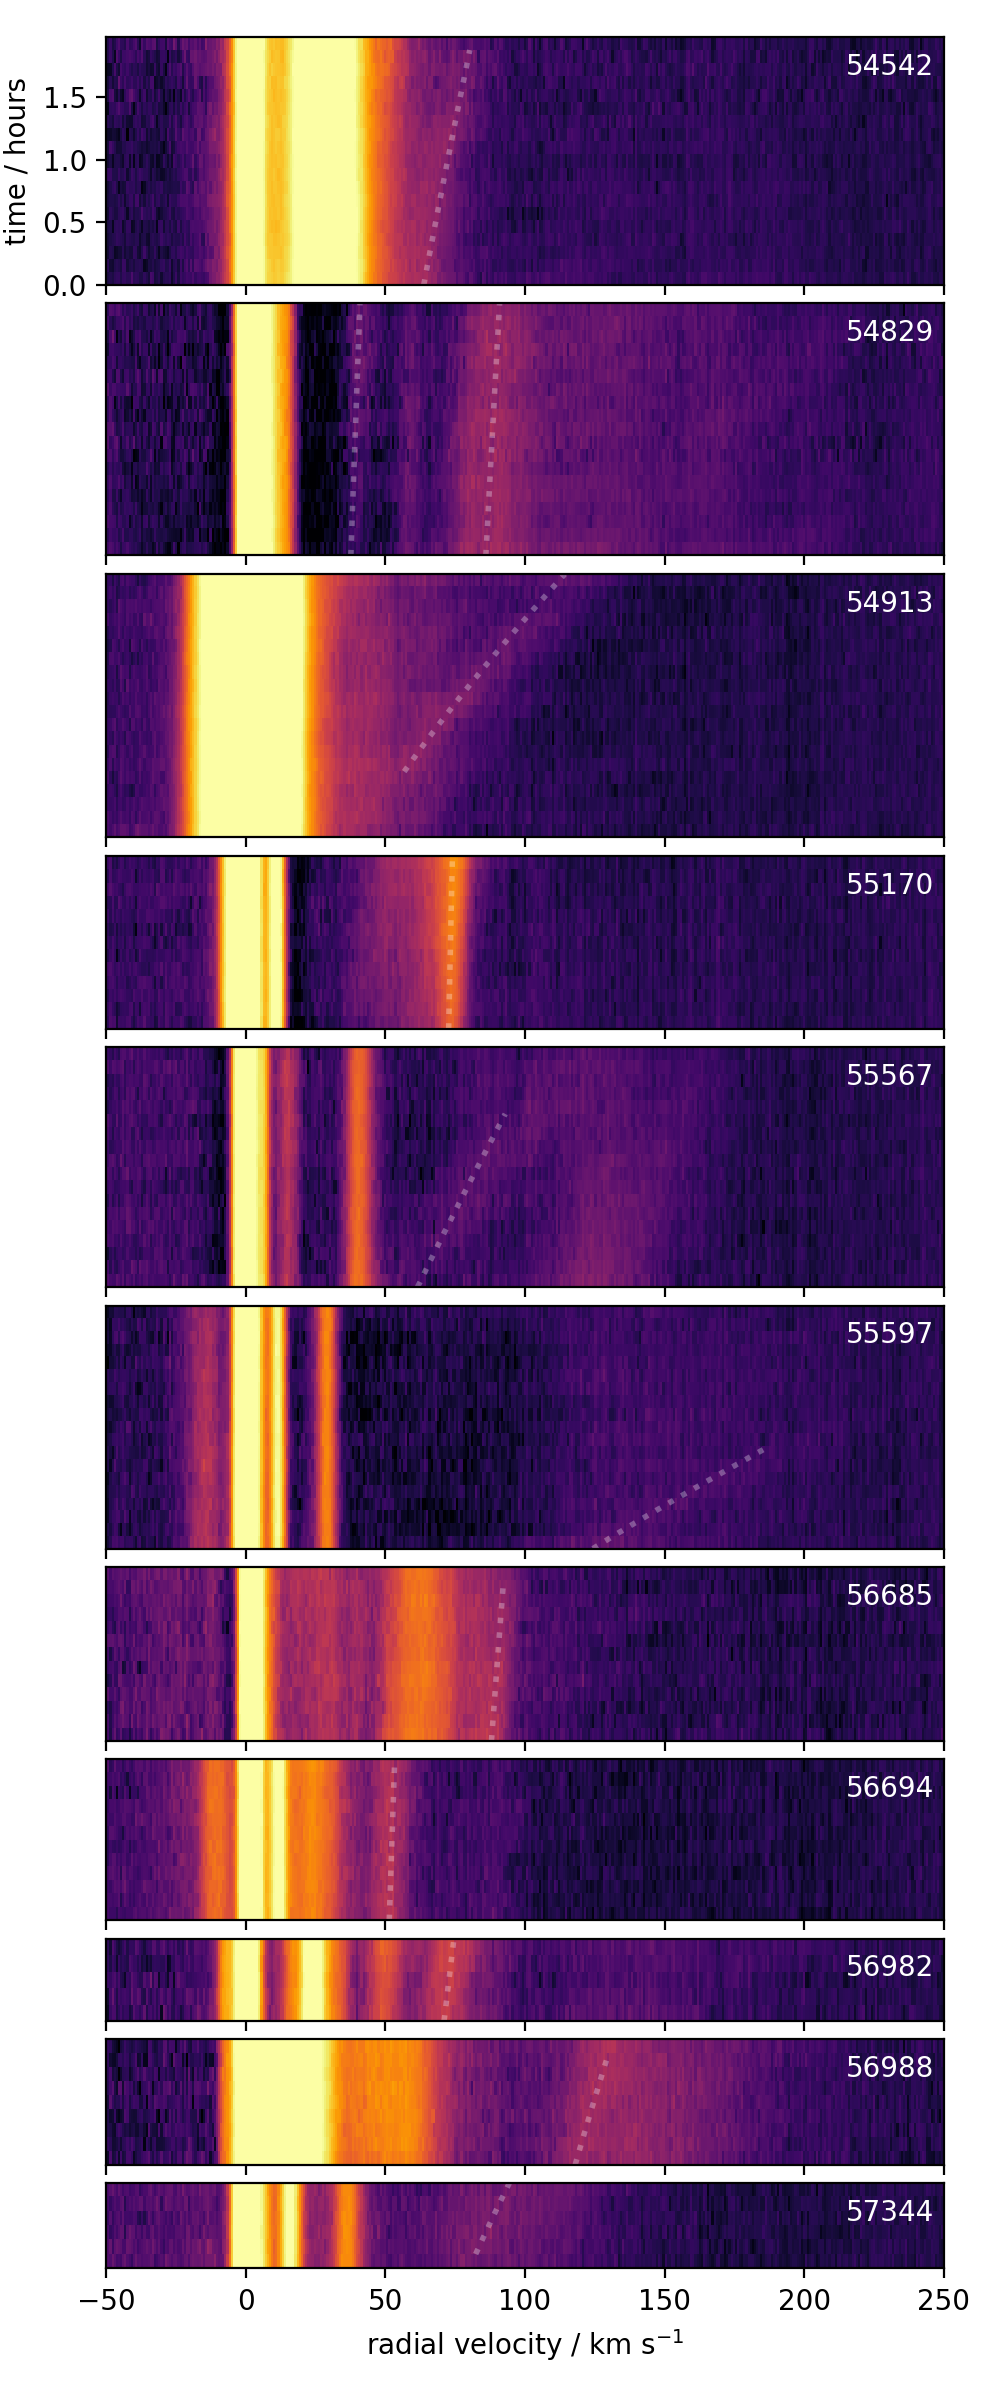

<IPython.core.display.Javascript object>


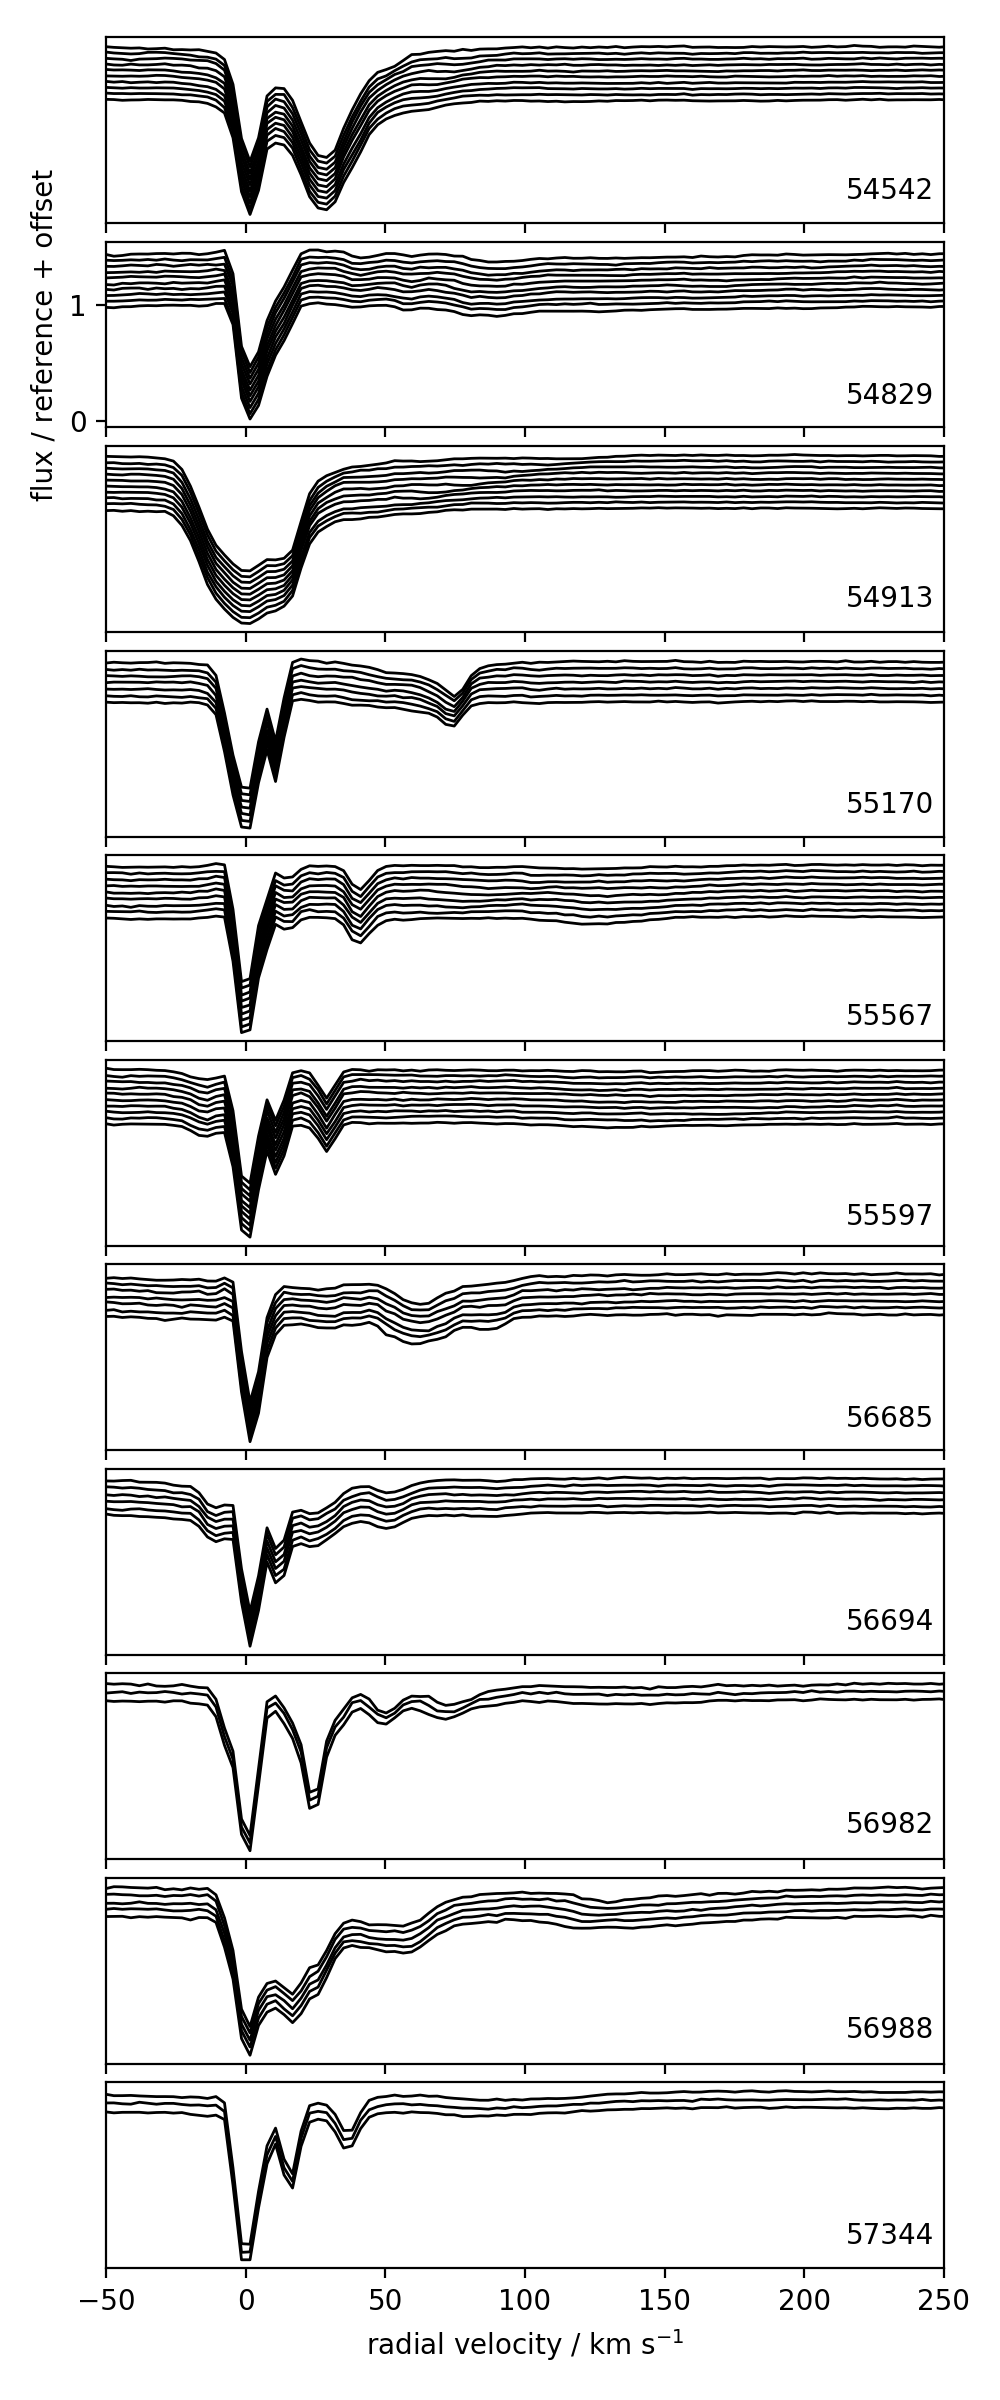

54542.01919165
54829.12297831
54912.99756498
55170.17195236
55567.1748119
55597.08481169
56685.17389625
56694.03998097
56982.33467356
56988.19925167
57344.23168546


In [13]:
# put all on a single plot

# rebin spectrally
# bin = 4
# rv = rebin(rv, bin)
# mean_spec_nocs = rebin(mean_spec_nocs, bin)

ii = [0,4,8,10,13,14,18,19,24,25,27]
dt = []
for i in ii:
    d1,d2 = date_ranges[i]
    dt += [d2-d1]

fig,ax = plt.subplots(11, figsize=(5,12), sharex=True,
                     gridspec_kw={'height_ratios': dt})

fig1,ax1 = plt.subplots(11, figsize=(5,12), sharex=True)

for j,n in enumerate(ii):
    d1,d2 = date_ranges[n]
    print(d1)
    ds = np.linspace(d1, d2, int((d2 - d1)*250))
    img = np.zeros((len(ds)-1,len(spec[0])))
    nspec = 0
    for i in range(len(ds)-1):
        ok = (date > ds[i]) & (date <= ds[i+1]) & (std < std_thresh)
        nspec += np.sum(ok)
        if np.any(ok):
            img[i,:] = np.mean(spec[ok,:],axis=0)

#     for i,s in enumerate(img):
#         img[i,:len(rv)] = rebin(s,bin)
#     img = img[:,:len(rv)]

#     print('{}, {} spectra in {} bins'.format(i, nspec, img.shape[0]))
    
    hs = (ds - ds[0]) * 24
    ok = np.sum(img,axis=1) != 0
    med = np.median(img[ok], axis=0)
    sub = np.zeros((img.shape))
    for i,im in enumerate(img):
        if np.sum(im) > 0:
            sub[i] = im - med

    filt = medfilt2d(sub, kernel_size=(3,131))
    sub -= filt
    img -= filt

    ax[j].imshow(np.log(1.1 - img/mean_spec_nocs), origin='bottom', aspect='auto', 
                 vmin=-2.5, vmax=-0.5, cmap='inferno',
                 extent=(rv[0],rv[-1],hs[0],hs[-1]),
                 zorder=-2)

#     ax[j].imshow(sub, origin='bottom', aspect='auto', 
#                  vmin=-2e-2, vmax=2e-2, cmap='viridis',
#                  extent=(rv[0],rv[-1],hs[0],hs[-1]))
    
    fs = glob.glob('/Users/grant/a-extra/archive/fits_calx/{}*/para_best_par.npy'.format(int(round(d1))))
    for f in fs:
        nu, q, t0, _, _ = np.load(f)
        in_tr, rv_mod = orbit_rv(nu, q, t0, hs, e=1)
        if (np.max(rv_mod)-np.min(rv_mod)) > 1.3e3:
            ax[j].plot(rv_mod[in_tr]/1e3, hs[in_tr], ':w', linewidth=2, alpha=0.3, zorder=-1)
    
    ax[j].text(215, hs[-1]-0.3, '{:5.0f}'.format(d1), color='w')
    ax[j].get_yaxis().set_visible(False)
    ax[j].set_rasterization_zorder(0)
    
    for i in np.arange(0, img.shape[0], 2):
        try:
            s = np.mean(img[i:i+2],axis=0)
        except:
            s = np.mean(img[i:],axis=0)
            
        ax1[j].plot(rebin(rv,4), i/40. + rebin(s,4)/rebin(mean_spec_nocs,4),
                    color='black', linewidth=1, alpha=1)

    ax1[j].get_yaxis().set_visible(False)
    ax1[j].text(215, 0.15, '{:5.0f}'.format(d1), color='black')

ax[0].get_yaxis().set_visible(True)
ax[0].set_ylabel('time / hours')
ax[0].set_xlim(-50, 250)
ax[-1].set_xlabel('radial velocity / km s$^{-1}$')

ax1[1].get_yaxis().set_visible(True)
ax1[1].set_ylabel('flux / reference + offset')
ax1[0].set_xlim(-50, 250)
ax1[-1].set_xlabel('radial velocity / km s$^{-1}$')

fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
fig.savefig('/Users/grant/astro/doc/feb-accel/all.eps', rasterized=True, dpi=300)

fig1.tight_layout()
fig1.subplots_adjust(hspace=0.1)
fig1.savefig('/Users/grant/astro/doc/feb-accel/all_spec.eps', rasterized=True, dpi=300)